In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_excel('full-data-acoustic-logger-leakage-challenge-january-update.xlsx', engine='openpyxl')

Finding the most common pipe diameters.
Pipe diameter calculations to see common pipe diameters so that the robot can be the right size

<ipython-input-3-b26f5b3e4f66>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pipe_diameters['PipeAllmm'] = np.where(pipe_diameters["Units"] == 'In',pipe_diameters['Diameter']*25.4,pipe_diameters['Diameter'])


(array([2.6200e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.5500e+02,
        4.8000e+01, 4.0000e+00, 0.0000e+00, 3.5190e+03, 0.0000e+00,
        1.0549e+04, 0.0000e+00, 5.1401e+04, 1.0250e+03, 0.0000e+00,
        2.3397e+04, 7.5394e+04, 0.0000e+00, 4.2700e+02, 0.0000e+00,
        1.3432e+04, 2.9400e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        2.2086e+04, 6.0000e+02, 0.0000e+00, 0.0000e+00, 6.7400e+02,
        5.6920e+03, 0.0000e+00, 0.0000e+00, 3.0490e+03, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 2.0000e+00, 1.0460e+03, 0.0000e+00,
        0.0000e+00, 7.6500e+02, 6.5200e+02, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        6.3900e+02, 0.0000e+00, 4.9000e+01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 4.4000e+01, 3.7000e+01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 5.0000e+01, 0.0000e+00,
        0.0000e+00, 3.8000e+01, 2.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

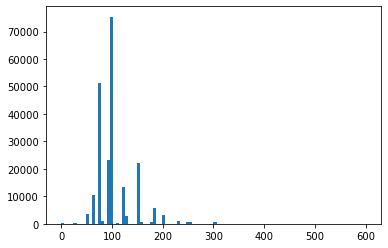

In [3]:
## create new df with only relevant columns
pipe_diameters = data[["Diameter","Units", "pipeType"]]
## convert from inches to mm where the unit column is inches
pipe_diameters['PipeAllmm'] = np.where(pipe_diameters["Units"] == 'In',pipe_diameters['Diameter']*25.4,pipe_diameters['Diameter'])
## find max pipe diameter to create better graphs
## outlier is a raw water main that transports water from source to treatment facility - can be ignored for this project
max_pipe_diameter = pipe_diameters['PipeAllmm'].max()
max_pipe_diameter_index = pipe_diameters['PipeAllmm'].idxmax()
## remove raw water mains as these are of no interest to us - we are focused on post treatment distribution
# pipe_diameters = pipe_diameters[pipe_diameters.pipeType != "Raw Water Main"] ##leave this in for now
# max_pipe_diameter = pipe_diameters['PipeAllmm'].max()
# max_pipe_diameter_index = pipe_diameters['PipeAllmm'].idxmax()
#### Separate by pipe types - two main types trunk and distribution , others are washout, private, proposed, abandoned, raw

distribution_diameters = pipe_diameters[pipe_diameters.pipeType == "Distribution Main"]
trunk_diameters = pipe_diameters[pipe_diameters.pipeType == "Trunk Main"]
raw_water_diameters = pipe_diameters[pipe_diameters.pipeType == "Raw Water Main"]
washout_diameters = pipe_diameters[pipe_diameters.pipeType == "Washout Main - Potab"]
private_diameters = pipe_diameters[pipe_diameters.pipeType == "Private Main"]
proposed_diameters = pipe_diameters[pipe_diameters.pipeType == "Proposed Main"]
abandoned_diameters = pipe_diameters[pipe_diameters.pipeType == "Abandoned Main"]

## create histogram
#comment all but one to see individually

plt.hist(distribution_diameters['PipeAllmm'], bins=100)
# plt.hist(trunk_diameters['PipeAllmm'],color='black')
# plt.hist(washout_diameters['PipeAllmm'],color='green')
# plt.hist(private_diameters['PipeAllmm'], color ='red', bins = 100)
# plt.hist(proposed_diameters['PipeAllmm'], color='orange')
# plt.hist(abandoned_diameters['PipeAllmm'],color='grey')
# plt.hist(raw_water_diameters['PipeAllmm'],color='pink')

Looking at pipe age and material

c:\Python38\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
c:\Python38\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([1.1173e+04, 2.5616e+04, 1.2758e+04, 7.8000e+01, 8.3000e+01,
        8.5000e+01, 1.7000e+01, 2.6000e+01, 6.0000e+00, 6.0000e+00]),
 array([  0.18356164,  12.12794521,  24.07232877,  36.01671233,
         47.96109589,  59.90547945,  71.84986301,  83.79424658,
         95.73863014, 107.6830137 , 119.62739726]),
 <a list of 10 Patch objects>)

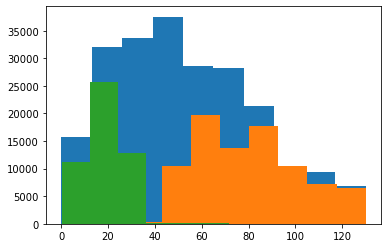

In [8]:
## create a new df with necessary columns

pipe_material_age = data[["Material", "Age_of_Pipe"]]

## see unique materials and count their values

# clearly iron is the main material with cast being the biggest and then 
# other forms of iron also accounting for another 8 or so percent
# print(pipe_material_age["Material"].unique())
unique_material_counts = pipe_material_age["Material"].value_counts(normalize=True)

## Pipe age stuff


plt.hist(pipe_material_age["Age_of_Pipe"])

# abandoned_diameters = pipe_diameters[pipe_diameters.pipeType == "Abandoned Main"]

plt.hist(pipe_material_age[pipe_material_age.Material == 'Cast Iron']["Age_of_Pipe"])
plt.hist(pipe_material_age[pipe_material_age.Material == 'Polyethylene']["Age_of_Pipe"])
